In [1]:
# In this notebook, we will evaluate the results from the fully conv compression ratio experiments


In [2]:

import pathlib
import logging
logging.basicConfig(level=logging.INFO)

from src.eval_utils import *
from notebooks.computers_and_fluids_2025.eval_functions import *

#base_output_dir = pathlib.Path('/Volumes/My Passport for Mac/Multiphase-ae/lassen_output')
base_dir = pathlib.Path('../../output/lassen')
files = list(base_dir.glob('interfacial_ae_v32_*'))

print(len(files))

179


Could not read ../../output/lassen/interfacial_ae_v32_run_144_datadirTANH_EPSILON0125_lossl1_lr0001_weightdecay00001_acttypesilu
Could not read ../../output/lassen/interfacial_ae_v32_run_145_datadirTANH_EPSILON0125_lossl1_lr0001_weightdecay00001_acttyperelu
Could not read ../../output/lassen/interfacial_ae_v32_run_62_datadirHEAVISIDE_lossmse_lr00001_weightdecay00001_acttypetanh
Could not read ../../output/lassen/interfacial_ae_v32_run_01_datadirSIGNED_DISTANCE_EXACT_lossl1_lr0001_weightdecay00001_acttyperelu


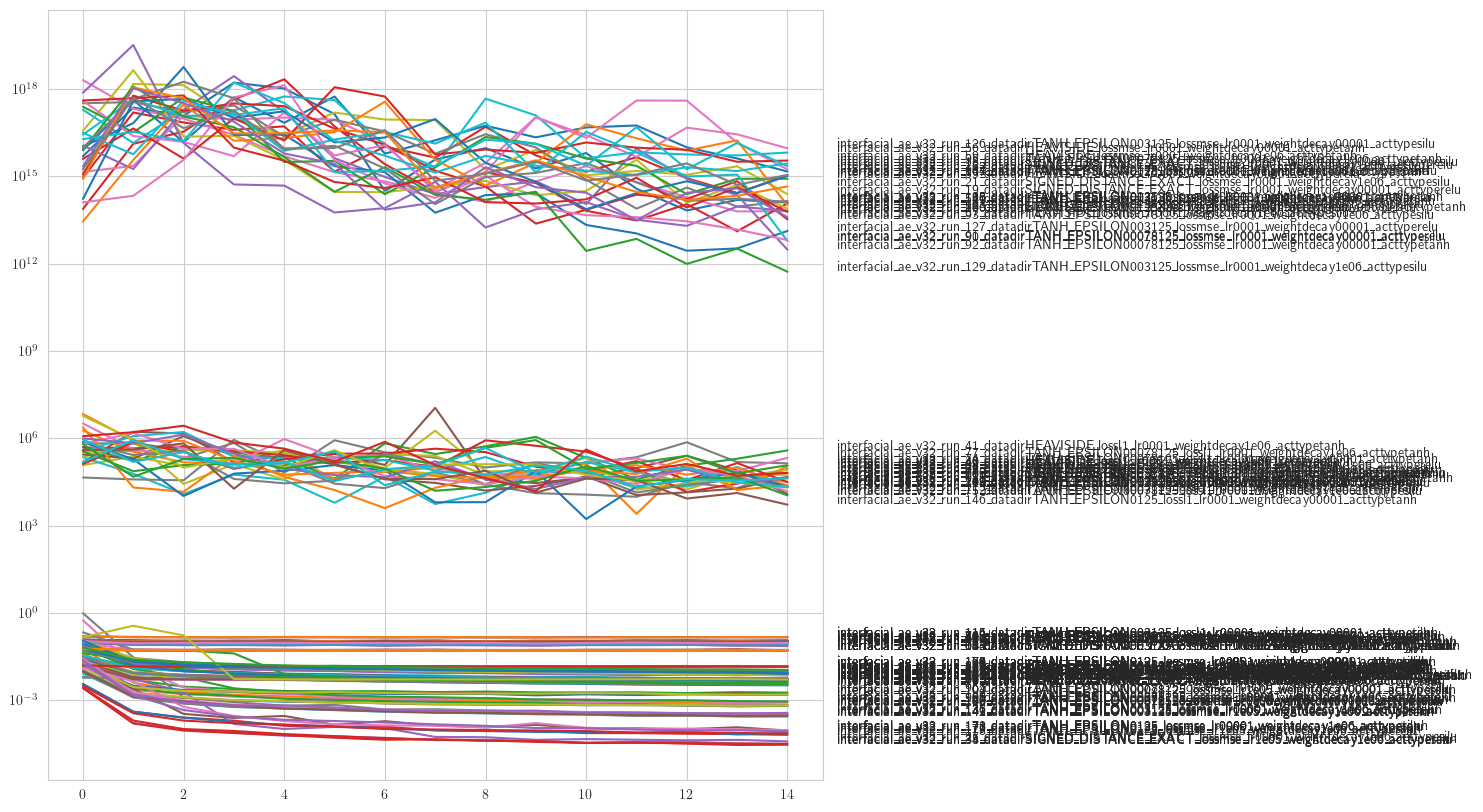

In [3]:
# Compare all the loss curves on one axis

name_to_loss = {}

for f in files:
    try:
        name_to_loss[f] = read_loss_curve_from_file(f)
    except:
        print(f'Could not read {f}')

fig, ax = plt.subplots(figsize=(10, 10))
loss_component = 'Total'
for f, loss in name_to_loss.items():
    ax.plot(loss[loss_component], label=f.name)

    # Annotate name on the end of the curve
    ax.text(len(loss[loss_component]), loss[loss_component][-1], f.name)
#ax.legend()
ax.set_yscale('log')
plt.show()



In [4]:

def extract_interface_type(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-4])
    final_part = final_part.replace('datadir', '')

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
        'SIGNED_DISTANCE_APPROXIMATE': InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
    }

    return str_to_type[final_part]

def extract_epsilon(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-4])
    final_part = final_part.replace('datadir', '')

    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
        'SIGNED_DISTANCE_APPROXIMATE': None,
    }

    return str_to_epsilon[final_part]


def get_dataset_path(interfacetype, epsilon):
    if interfacetype == InterfaceType.TANH_EPSILON:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON{epsilon}')
    elif interfacetype == InterfaceType.HEAVISIDE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_EXACT:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT')
    elif interfacetype == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return pathlib.Path(f'/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE')
    else:
        raise ValueError('Unknown interface type')


def _extract_part(stem, key):
    idx = stem.find(key)
    if idx == -1:
        raise ValueError(f"Key '{key}' not found in stem '{stem}'")
    start = idx + len(key)
    end = stem.find('_', start)
    if end == -1:
        return stem[start:]
    return stem[start:end]

def extract_loss(outdir):
    return _extract_part(outdir.stem, 'loss')

def extract_lr(outdir):
    lr_str = _extract_part(outdir.stem, 'lr')

    if 'e' in lr_str:
        return float(lr_str.replace('e', 'e-') if 'e' in lr_str and '-' not in lr_str else lr_str)
    else:
        num_zeros = len(lr_str) - 1
        lr = 10**(-1 * num_zeros)
        return lr

def extract_weight_decay(outdir):
    wd_str = _extract_part(outdir.stem, 'weightdecay')

    if 'e' in wd_str:
        return float(wd_str.replace('e', 'e-') if 'e' in wd_str and '-' not in wd_str else wd_str)
    else:
        num_zeros = len(wd_str) - 1
        wd = 10**(-1 * num_zeros)
        return wd

def extract_act_type(outdir):
    return _extract_part(outdir.stem, 'acttype')

In [5]:
outdir_to_params = {}

for outdir in files:
    print(outdir)

    interfacetype = extract_interface_type(outdir)
    epsilon = extract_epsilon(outdir)
    model_path = get_model_path(outdir, epoch=15)
    dim_mults = get_dim_mults(outdir)
    dataset_path = get_dataset_path(interfacetype, epsilon)
    loss = extract_loss(outdir)
    lr = extract_lr(outdir)
    weight_decay = extract_weight_decay(outdir)
    act_type = extract_act_type(outdir)

    if not model_path.exists():
        continue

    assert model_path.exists(), f'{model_path} does not exist'
    assert dataset_path.exists(), f'{dataset_path} does not exist'
   
    params = {
       'interface_type': interfacetype,
       'epsilon': epsilon,
       'model_path': model_path,
       'dataset_path': dataset_path,
       'dim_mults': dim_mults,
        'loss': loss,
        'lr': lr,
        'weight_decay': weight_decay,
        'act_type': act_type,
    }
   
    outdir_to_params[outdir] = params
    
print(outdir_to_params)

../../output/lassen/interfacial_ae_v32_run_130_datadirTANH_EPSILON003125_lossmse_lr0001_weightdecay1e06_acttyperelu
../../output/lassen/interfacial_ae_v32_run_124_datadirTANH_EPSILON003125_lossl1_lr1e05_weightdecay1e06_acttyperelu
../../output/lassen/interfacial_ae_v32_run_79_datadirTANH_EPSILON00078125_lossl1_lr00001_weightdecay00001_acttyperelu
../../output/lassen/interfacial_ae_v32_run_164_datadirTANH_EPSILON0125_lossmse_lr0001_weightdecay00001_acttypetanh
../../output/lassen/interfacial_ae_v32_run_114_datadirTANH_EPSILON003125_lossl1_lr00001_weightdecay00001_acttypesilu
../../output/lassen/interfacial_ae_v32_run_78_datadirTANH_EPSILON00078125_lossl1_lr00001_weightdecay00001_acttypesilu
../../output/lassen/interfacial_ae_v32_run_58_datadirHEAVISIDE_lossmse_lr0001_weightdecay1e06_acttyperelu
../../output/lassen/interfacial_ae_v32_run_74_datadirTANH_EPSILON00078125_lossl1_lr0001_weightdecay00001_acttypetanh
../../output/lassen/interfacial_ae_v32_run_144_datadirTANH_EPSILON0125_lossl1_

In [ ]:
# Run inference for all - time consuming cell!

k = 0
for outdir, params in outdir_to_params.items():
    k += 1
    print('=' * 64)
    print(f"Dir {k} of {len(outdir_to_params)}")
    print('=' * 64)

    outfile = outdir / 'inference.npz'

    if outfile.exists():
        #continue
        pass

    dataset = load_dataset(params['dataset_path'], max_num_samples=25_000, split='hyperparam_val')
    model = load_model(params['model_path'], dim_mults=params['dim_mults'])
    gts, preds = run_inference(dataset, model, N=50)
    
    # Save outdir, preds, params, gt to disk, ready to be reloaded at evaluation time!
    
    np.savez_compressed(outfile, gts=gts, preds=preds, **params)

Dir 1 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


  0%|          | 0/50 [00:00<?, ?it/s]/Users/murray/miniconda3/envs/mfe/lib/python3.12/site-packages/torch/nn/functional.py:4538: UserWarning: The operator 'aten::upsample_nearest3d.vec' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_nearest3d(input, output_size, scale_factors)
100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Dir 2 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 3 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 4 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 5 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 6 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 7 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:c

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 8 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 9 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 10 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 11 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 12 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 13 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 14 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:c

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 15 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 16 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 17 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 18 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])
INFO:c

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 19 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 20 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 21 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 22 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 23 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 24 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 25 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 26 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 27 of 175


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_52.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shap

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Dir 28 of 175


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_53.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torc

Loading model to device: mps
Running inference on device: mps


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Dir 29 of 175


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=20000, val=3750
INFO:src.datasets.volumetric_datasets:Loaded 1250 files for split hyperparam_val
INFO:src.datasets.volumetric_datasets:First file: /Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-05-12-09-22-Folder_868_Restart_005_1.25253_patch_54.npz
INFO:src.datasets.volumetric_datasets:Generated 1250 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size

Loading model to device: mps
Running inference on device: mps


 94%|█████████▍| 47/50 [00:45<00:02,  1.03it/s]

In [ ]:
# Go over each file, and load predictions, compute metrics from each volume

outdir_to_metrics = {}

for outdir, params in outdir_to_params.items():
    print(outdir)
    outfile = outdir / 'inference.npz'
    data = np.load(outfile)
    
    gts = data['gts']
    preds = data['preds']
    
    # Convert to sharp interface
    interfacetype = params['interface_type']
    
    # Compute metrics
    # 2. Dice coefficient
    
    dices = []
    
    for gt, pred in zip(gts, preds):
        gt = get_phi_sharp(gt, interfacetype)
        pred = get_phi_sharp(pred, interfacetype)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
    print(np.mean(dices))
        
    outdir_to_metrics[outdir] = {
        'Dice': dices,
    }
    

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fractions import Fraction

def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"

# --- Assume outdir_to_params and outdir_to_metrics are pre-populated ---
# This part remains the same as your setup.

# --- Aggregate data into a list of records ---
all_run_data = []
for outdir, params in outdir_to_params.items():
    if outdir not in outdir_to_metrics:
        print(f"Warning: No metrics found for {outdir}. Skipping.")
        continue

    run_data = params.copy()
    run_data['mean_dice'] = np.mean(outdir_to_metrics[outdir]['Dice'])
    all_run_data.append(run_data)

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(all_run_data)


# --- **NEW**: Create a full, descriptive interface name ---
def create_full_interface_name(row):
    """Creates a descriptive name that includes epsilon where relevant."""
    # Handle Enums by getting their name, otherwise use the string itself
    interface_type_name = row['interface_type'].name if hasattr(row['interface_type'], 'name') else str(row['interface_type'])

    # If the interface is defined by an epsilon, include it in the name
    if 'TANH_EPSILON' in interface_type_name.upper():
        epsilon = row['epsilon']
        # You can customize the formatting here, e.g., f"{epsilon:.2f}"
        return f"TANH ({float_to_fraction(epsilon)})"
    else:
        # For other types like SDF, just use the name
        return interface_type_name.replace('SIGNED_DISTANCE_', 'SDF_')


# Apply the function to create the new column
df['full_interface_name'] = df.apply(create_full_interface_name, axis=1)


# --- Sanity check ---
# Display the DataFrame head to verify the new column
print("--- Aggregated DataFrame Head with Full Interface Name ---")
display_cols = ['full_interface_name', 'lr', 'loss', 'weight_decay', 'act_type', 'mean_dice']
# Filter to columns that actually exist in the dataframe
display_cols = [col for col in display_cols if col in df.columns]
print(df[display_cols].head())

In [ ]:
# Save df

df.to_csv('hyperparam_results.csv')